In [1]:
# Import libraries
import os
import keras
import pickle
import numpy as np

In [2]:
# Get a ResNet50 model
def resnet50_model(classes=4, *args, **kwargs):
    # Create an input layer 
    input = keras.layers.Input(shape=(None, None, 3))

     # Create output layers
    output = keras.layers.ZeroPadding2D(padding=3, name='padding_conv1')(input)
    output = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name='conv1')(output)
    output = keras.layers.BatchNormalization(axis=3, epsilon=1e-5, name='bn_conv1')(output)
    output = keras.layers.Activation('relu', name='conv1_relu')(output)
    output = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(output)
    output = conv_block(output, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='b')
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='c')
    output = conv_block(output, 3, [128, 128, 512], stage=3, block='a')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='b')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='c')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='d')
    output = conv_block(output, 3, [256, 256, 1024], stage=4, block='a')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='b')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='c')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='d')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='e')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='f')
    output = conv_block(output, 3, [512, 512, 2048], stage=5, block='a')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='b')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='c')
    output = keras.layers.GlobalAveragePooling2D(name='pool5')(output)
    output = keras.layers.Dense(classes, activation='softmax', name='fc1000')(output)

    # Create a model from input layer and output layers
    model = keras.models.Model(inputs=input, outputs=output, *args, **kwargs)
    # Print model
    print()
    print(model.summary(), '\n')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Return a model
    return model





In [3]:
# Create an identity block
def identity_block(input, kernel_size, filters, stage, block):
    
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create layers
    output = keras.layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    output = keras.layers.add([output, input])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output


In [4]:
# Create a convolution block
def conv_block(input, kernel_size, filters, stage, block, strides=(2, 2)):
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create block layers
    output = keras.layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input)
    shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)
    output = keras.layers.add([output, shortcut])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output

In [5]:
 # Create a data generator for training
from keras.preprocessing.image import ImageDataGenerator
train_data_generator = ImageDataGenerator(
        rescale=1./255, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True)

In [6]:
# Create a data generator for validation
validation_data_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True)

In [7]:
IMAGE_SIZE = [224, 224]

In [8]:
train_path = 'D:\Degree\BrainTumor_Impl\datasets\dataset1_cropped\Training'
valid_path = 'D:\Degree\BrainTumor_Impl\datasets\dataset1_cropped\Testing'

In [9]:
# Create a train generator
train_generator = train_data_generator.flow_from_directory( 
        'D:\Degree\BrainTumor_Impl\datasets\dataset1_cropped\Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical'
                                                 )

Found 2870 images belonging to 4 classes.


In [10]:
test_set = validation_data_generator.flow_from_directory('D:\Degree\BrainTumor_Impl\datasets\dataset1_cropped\Testing',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 394 images belonging to 4 classes.


In [11]:
 # Get the model (4 categories)
model = resnet50_model(4)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 padding_conv1 (ZeroPadding2D)  (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['padding_conv1[0][0]']          
                                64)                                                          

                                                                                                  
 activation_5 (Activation)      (None, None, None,   0           ['add_1[0][0]']                  
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16448       ['activation_5[0][0]']           
                                64)                                                               
                                                                                                  
 bn2c_branch2a (BatchNormalizat  (None, None, None,   256        ['res2c_branch2a[0][0]']         
 ion)                           64)                                                               
                                                                                                  
 activatio

 ion)                           128)                                                              
                                                                                                  
 activation_13 (Activation)     (None, None, None,   0           ['bn3b_branch2b[0][0]']          
                                128)                                                              
                                                                                                  
 res3b_branch2c (Conv2D)        (None, None, None,   66048       ['activation_13[0][0]']          
                                512)                                                              
                                                                                                  
 bn3b_branch2c (BatchNormalizat  (None, None, None,   2048       ['res3b_branch2c[0][0]']         
 ion)                           512)                                                              
          

 activation_21 (Activation)     (None, None, None,   0           ['bn4a_branch2a[0][0]']          
                                256)                                                              
                                                                                                  
 res4a_branch2b (Conv2D)        (None, None, None,   590080      ['activation_21[0][0]']          
                                256)                                                              
                                                                                                  
 bn4a_branch2b (BatchNormalizat  (None, None, None,   1024       ['res4a_branch2b[0][0]']         
 ion)                           256)                                                              
                                                                                                  
 activation_22 (Activation)     (None, None, None,   0           ['bn4a_branch2b[0][0]']          
          

                                                                                                  
 add_9 (Add)                    (None, None, None,   0           ['bn4c_branch2c[0][0]',          
                                1024)                             'activation_26[0][0]']          
                                                                                                  
 activation_29 (Activation)     (None, None, None,   0           ['add_9[0][0]']                  
                                1024)                                                             
                                                                                                  
 res4d_branch2a (Conv2D)        (None, None, None,   262400      ['activation_29[0][0]']          
                                256)                                                              
                                                                                                  
 bn4d_bran

                                256)                                                              
                                                                                                  
 res4f_branch2c (Conv2D)        (None, None, None,   263168      ['activation_37[0][0]']          
                                1024)                                                             
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, None, None,   4096       ['res4f_branch2c[0][0]']         
 ion)                           1024)                                                             
                                                                                                  
 add_12 (Add)                   (None, None, None,   0           ['bn4f_branch2c[0][0]',          
                                1024)                             'activation_35[0][0]']          
          

 bn5c_branch2a (BatchNormalizat  (None, None, None,   2048       ['res5c_branch2a[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 activation_45 (Activation)     (None, None, None,   0           ['bn5c_branch2a[0][0]']          
                                512)                                                              
                                                                                                  
 res5c_branch2b (Conv2D)        (None, None, None,   2359808     ['activation_45[0][0]']          
                                512)                                                              
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, None, None,   2048       ['res5c_branch2b[0][0]']         
 ion)     

In [12]:
epochs = 1
batch_size = 32
train_samples = 4 * 500 # 4 categories with 500 images in each category
validation_samples = 4 * 100 # 4 categories with 100 images in each category

In [14]:
m = model.fit_generator( 
        train_generator, 
        steps_per_epoch=train_samples // batch_size, 
        validation_data=test_set, 
        validation_steps=validation_samples // batch_size,
        epochs=50)

C:\Users\krish\AppData\Local\Temp\ipykernel_9816\2016399070.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  m = model.fit_generator(


Epoch 1/50
62/62 [==============================] - 872s 14s/step - loss: 1.4942 - accuracy: 0.4732 - val_loss: 1659.4122 - val_accuracy: 0.3255
Epoch 2/50
62/62 [==============================] - 851s 14s/step - loss: 0.9730 - accuracy: 0.6266 - val_loss: 74.7989 - val_accuracy: 0.2630
Epoch 3/50
62/62 [==============================] - 856s 14s/step - loss: 0.8696 - accuracy: 0.6682 - val_loss: 10.7109 - val_accuracy: 0.2552
Epoch 4/50
62/62 [==============================] - 860s 14s/step - loss: 0.7384 - accuracy: 0.7194 - val_loss: 3.9859 - val_accuracy: 0.2656
Epoch 5/50
62/62 [==============================] - 867s 14s/step - loss: 0.6431 - accuracy: 0.7611 - val_loss: 4.3973 - val_accuracy: 0.3229
Epoch 6/50
62/62 [==============================] - 888s 14s/step - loss: 0.6650 - accuracy: 0.7427 - val_loss: 48.3306 - val_accuracy: 0.3620
Epoch 7/50
62/62 [==============================] - 762s 12s/step - loss: 0.6658 - accuracy: 0.7401 - val_loss: 29.7962 - val_accuracy: 0.2526

In [29]:
 # Save model to disk
model.save('ResNet50_brain_tumor_classification_try4_model1.h5')
print('Saved model to disk!')


Saved model to disk!


In [19]:
acc = m.history['accuracy']
val_acc = m.history['val_accuracy']
loss = m.history['loss']
val_loss = m.history['val_loss']

In [21]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9685916900634766\nValidation Accuracy: 0.6119791865348816')

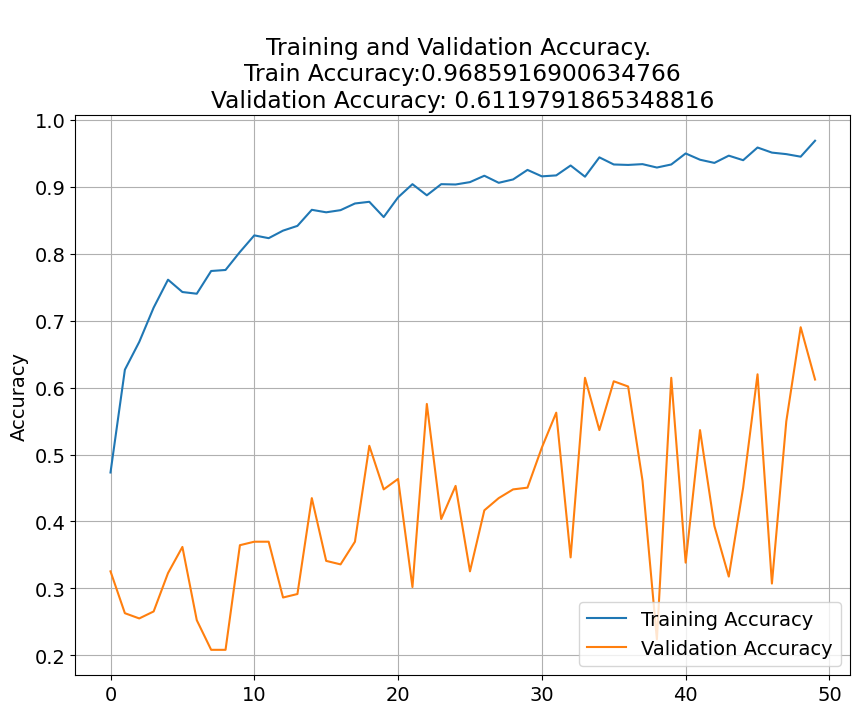

In [22]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

Text(0.5, 1.0, '\nTraining and Validation Loss. \nTrain Loss:0.08809227496385574\nValidation Loss: 3.7719085216522217')

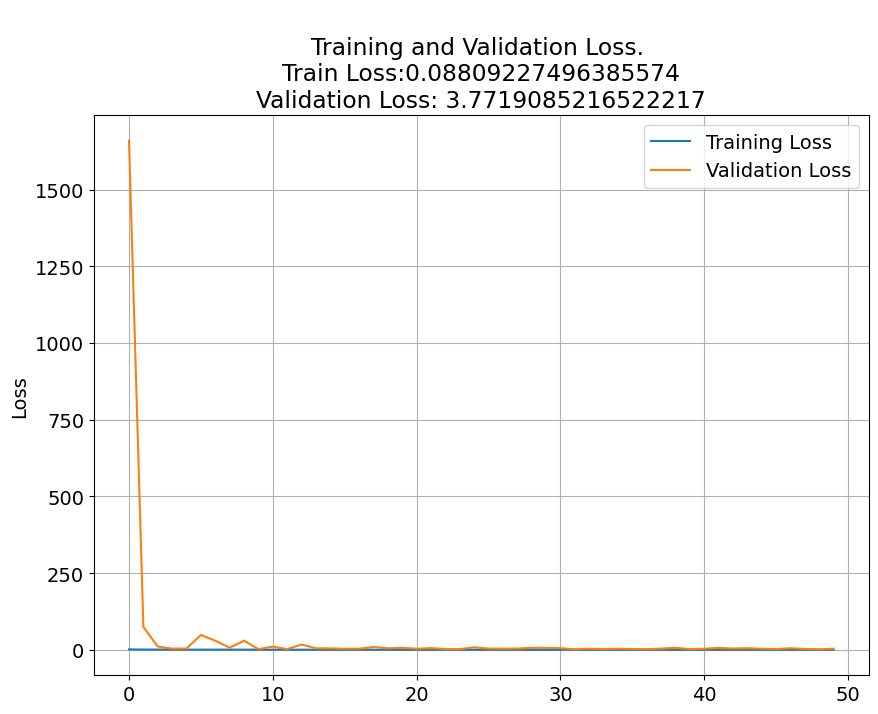

In [27]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title(f'\nTraining and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')

In [13]:
    # Get labels
labels = train_generator.class_indices


In [14]:
labels.keys()

dict_keys(['Glioma', 'Meningioma', 'No Tumor', 'Pituitory'])

In [15]:
labels.values()

dict_values([0, 1, 2, 3])

In [16]:
#Another way of model fitting
# fit the model
r = model.fit(
  train_generator,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_set)
)
#Save this model seprately

Epoch 1/50
90/90 [==============================] - 1328s 15s/step - loss: 1.4639 - accuracy: 0.5021 - val_loss: 1.6406 - val_accuracy: 0.2640
Epoch 2/50
90/90 [==============================] - 1234s 14s/step - loss: 0.8888 - accuracy: 0.6530 - val_loss: 2.5083 - val_accuracy: 0.3452
Epoch 3/50
90/90 [==============================] - 1082s 12s/step - loss: 0.7309 - accuracy: 0.7118 - val_loss: 15.5617 - val_accuracy: 0.2030
Epoch 4/50
90/90 [==============================] - 1055s 12s/step - loss: 0.6423 - accuracy: 0.7735 - val_loss: 4.1333 - val_accuracy: 0.3020
Epoch 5/50
90/90 [==============================] - 1036s 12s/step - loss: 0.5589 - accuracy: 0.7882 - val_loss: 24.0473 - val_accuracy: 0.2437
Epoch 6/50
90/90 [==============================] - 1040s 12s/step - loss: 0.5231 - accuracy: 0.8010 - val_loss: 121.3602 - val_accuracy: 0.2995
Epoch 7/50
90/90 [==============================] - 1220s 14s/step - loss: 0.4874 - accuracy: 0.8272 - val_loss: 3.0073 - val_accuracy: 0.

In [17]:
 # Save model to disk
model.save('ResNet50_brain_tumor_classification_try4_model2.h5')
print('Saved model to disk!')

Saved model to disk!


In [18]:
import matplotlib.pyplot as plt
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9742160439491272\nValidation Accuracy: 0.624365508556366')

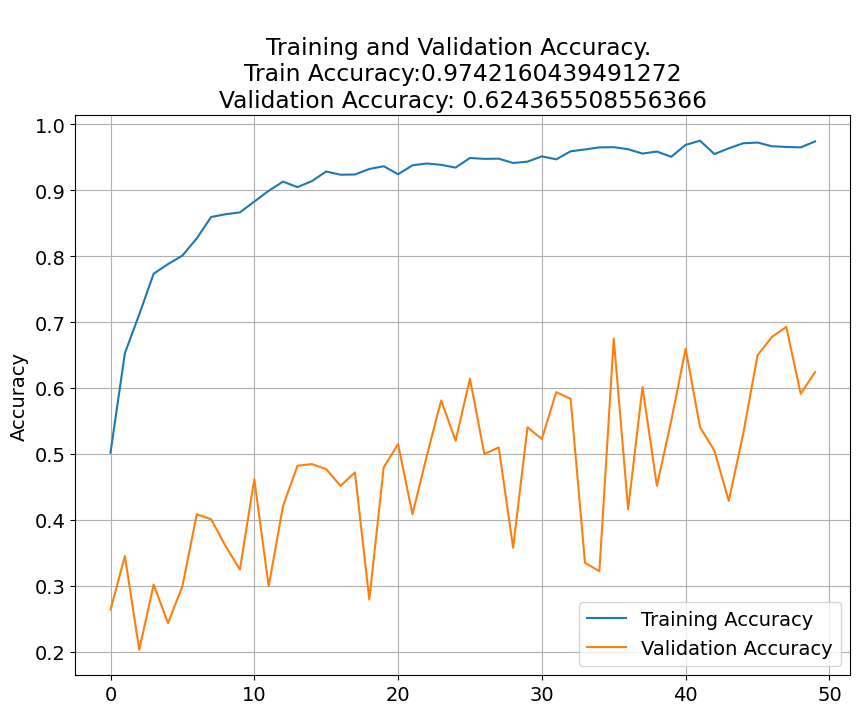

In [19]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

Text(0.5, 1.0, '\nTraining and Validation Loss. \nTrain Loss:0.07898618280887604\nValidation Loss: 3.659038782119751')

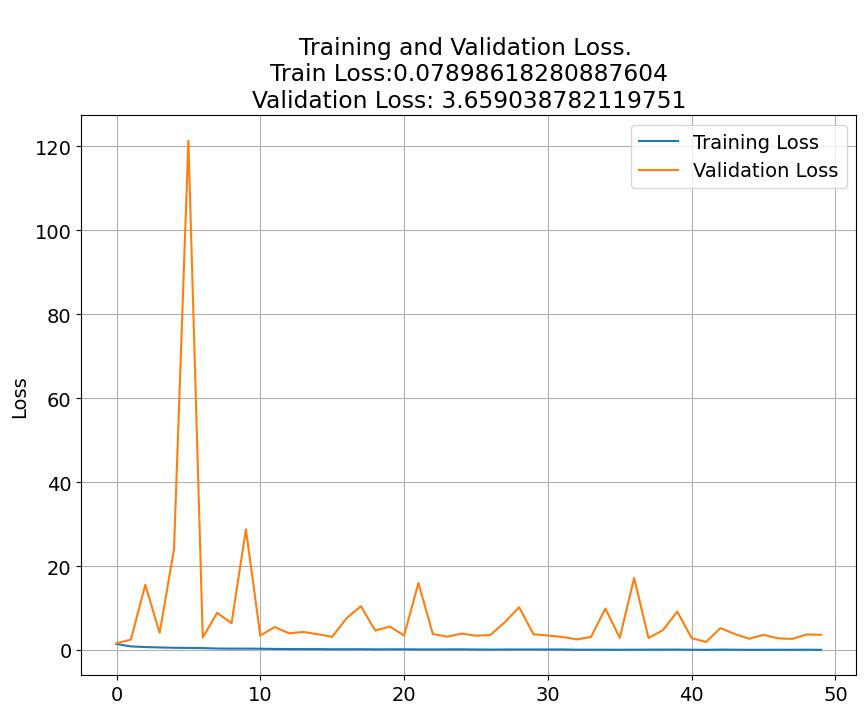

In [20]:
# plot results
# Loss
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title(f'\nTraining and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')

In [22]:
accuracy_score = model.evaluate(test_set)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

13/13 [==============================] - 32s 2s/step - loss: 3.7172 - accuracy: 0.6168
[3.7172129154205322, 0.6167512536048889]
Accuracy: 61.6751%
Loss:  3.7172129154205322
